What Should I Do When Confronted With Missing Data?

>Dataset: https://www.kaggle.com/competitions/titanic/data

Bekir Semih Tekeli-21889919
Ayşe Şule Bakal-21626991

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import impyute
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

In [230]:
# reference: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Reading Datasets and Detecting Missing Values

In [231]:
df_train = pd.read_csv("train.csv")

In [232]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [233]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [234]:
train_missing = missing_values_table(df_train)
train_missing

Your selected dataframe has 12 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


<AxesSubplot: >

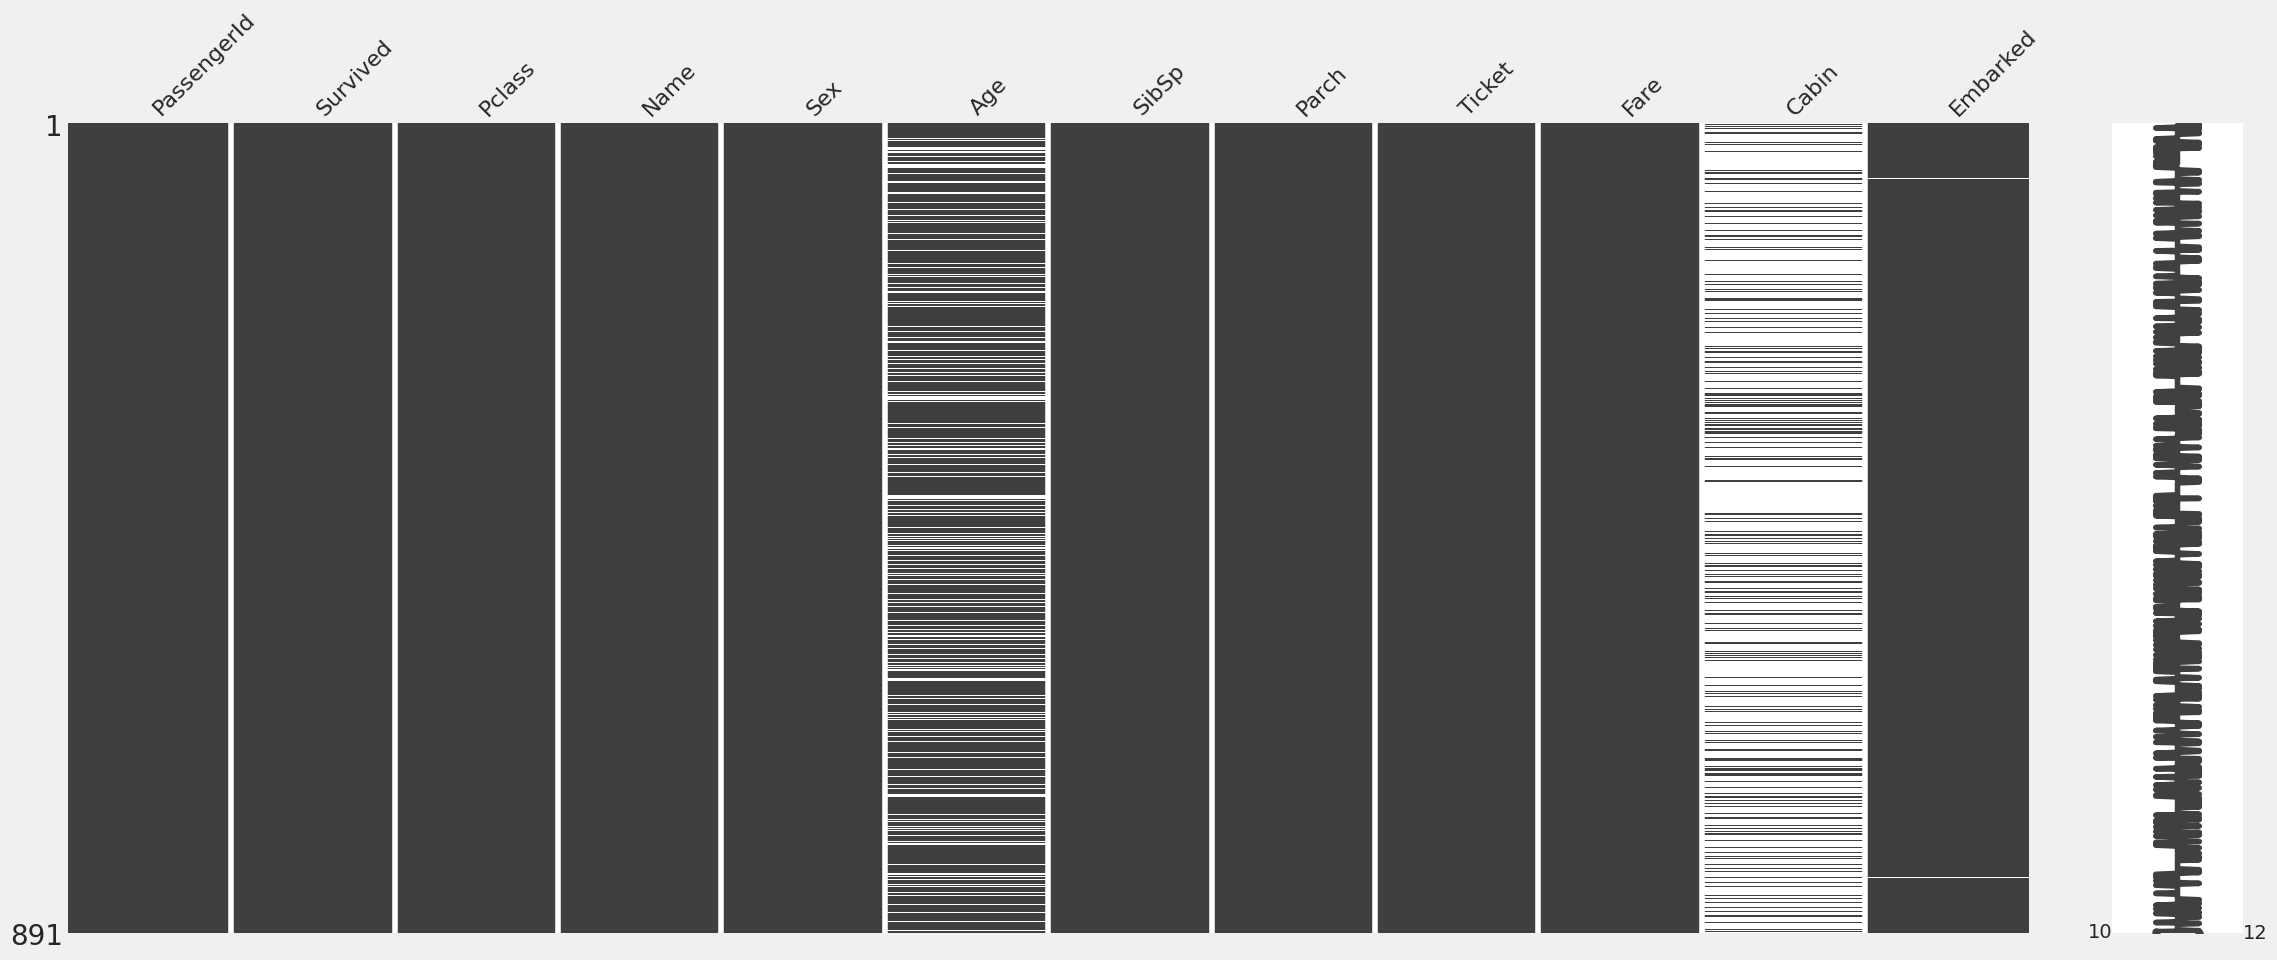

In [235]:
msno.matrix(df_train)

# DELETIONS
The term deletion refers to the removal of missing values from a dataset. However, as it could lead to the dataset's information being lost, this is not recommended. If the proportion of missing values in a dataset is really low, we should merely remove them. There are three further types of deletions:

## Pairwise Deletion
>In the case of MCAR, where values are completely missing at random, pairwise deletion is applied. Only the missing values are eliminated during Pairwise deletion. Inherently, all operations in Pandas, including mean, sum, and others, bypass missing data.

In [236]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [237]:
#pandas skips the missing values and calculates sum of the remaining values.
df_train["Age"].sum()

21205.17

## Listwise Deletion
>Complete rows (which include the missing values) are discarded during listwise deletion. It is also known as Complete Case deletion as a result. Listwise deletions are also only applied to MCAR values, similar to Pairwise deletion.

In [238]:
#Drop rows which contains any NaN or missing value for Age column
df_train_copy = df_train.copy()
df_train_copy.dropna(subset=['Age'], how='any', inplace=True)
df_train_copy['Age'].isnull().sum()

0

There are no empty values in the Age column. Listwise deletion has the primary drawback of deleting a significant portion of data, which results in the loss of a great deal of information. Therefore, it is best to utilize it only when there are very few missing values.


## Deleting Columns

>You could want to delete a feature if it is not significant and a column has a significant number of missing values, let's say more than 80%. Nevertheless, deleting data is not an appropriate method.


In [239]:
def compare(df_old, df_new, df3=None, df4=None, mode=False):
    part1 = df_old["Age"].iloc[40:50]
    part2 = df_new["Age"].iloc[40:50]
    df = pd.DataFrame()
    df["Original"] = part1
    if mode:
        part3 = df3["Age"].iloc[40:50]
        part4 = df4["Age"].iloc[40:50]
        df["Mean"] = part3
        df["Median"] = part4
        df["Common"] = part2
    else:
        df["Imputed"] = part2
    return df

# Imputation
Imputation is the process of substituting values for missing data. Depending on the situation and data, there are many different techniques to imputation the missing values.



In [240]:
# Display a part of original data with NaN values
df_train["Age"].iloc[40:50]

40    40.0
41    27.0
42     NaN
43     3.0
44    19.0
45     NaN
46     NaN
47     NaN
48     NaN
49    18.0
Name: Age, dtype: float64

## Impute with Constant

In [241]:
from sklearn.impute import SimpleImputer

df_train_constant = df_train.copy()
#setting strategy to 'constant'
constant_imputer = SimpleImputer(strategy='constant', fill_value=77.0)  # imputing using constant value
df_train_constant.iloc[:, :] = constant_imputer.fit_transform(df_train_constant)
compare(df_train, df_train_constant)

,Original,Imputed
40,40.0,40.0
41,27.0,27.0
42,NaN,77.0
43,3.0,3.0
44,19.0,19.0
45,NaN,77.0
46,NaN,77.0
47,NaN,77.0
48,NaN,77.0
49,18.0,18.0


## Impute with Common Value

In [242]:
from sklearn.impute import SimpleImputer

df_train_mean, df_train_median, df_train_most_frequent = df_train[["PassengerId", "Age"]].copy(), \
    df_train[["PassengerId", "Age"]].copy(), df_train[["PassengerId", "Age"]].copy()
mean_imputer = SimpleImputer(strategy='mean')  # imputing using mean
df_train_mean.iloc[:, :] = mean_imputer.fit_transform(df_train_mean)

median_imputer = SimpleImputer(strategy='median')  # imputing using median
df_train_median.iloc[:, :] = median_imputer.fit_transform(df_train_median)

frequent_imputer = SimpleImputer(strategy='most_frequent')  # imputing using most common value
df_train_most_frequent.iloc[:, :] = frequent_imputer.fit_transform(df_train_most_frequent)
compare(df_train,df_train_most_frequent,df_train_mean,df_train_median,True)

/tmp/ipykernel_6883/3496105702.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train_mean.iloc[:, :] = mean_imputer.fit_transform(df_train_mean)
/tmp/ipykernel_6883/3496105702.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train_median.iloc[:, :] = median_imputer.fit_transform(df_train_median)
/tmp/ipykernel_6883/3496105702.py:12: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals`

,Original,Mean,Median,Common
40,40.0,40.000000,40.0,40.0
41,27.0,27.000000,27.0,27.0
42,NaN,29.699118,28.0,24.0
43,3.0,3.000000,3.0,3.0
44,19.0,19.000000,19.0,19.0
45,NaN,29.699118,28.0,24.0
46,NaN,29.699118,28.0,24.0
47,NaN,29.699118,28.0,24.0
48,NaN,29.699118,28.0,24.0
49,18.0,18.000000,18.0,18.0


## Forward Fill

In [243]:
df_train_ff = df_train.copy()
df_train_ff.fillna(method='ffill', inplace=True)
compare(df_train, df_train_ff)

,Original,Imputed
40,40.0,40.0
41,27.0,27.0
42,NaN,27.0
43,3.0,3.0
44,19.0,19.0
45,NaN,19.0
46,NaN,19.0
47,NaN,19.0
48,NaN,19.0
49,18.0,18.0


## Backward Fill

In [244]:
df_train_bf = df_train.copy()
df_train_bf.fillna(method='bfill', inplace=True)
compare(df_train, df_train_bf)

,Original,Imputed
40,40.0,40.0
41,27.0,27.0
42,NaN,3.0
43,3.0,3.0
44,19.0,19.0
45,NaN,18.0
46,NaN,18.0
47,NaN,18.0
48,NaN,18.0
49,18.0,18.0


## KNN Based

In [245]:
from sklearn.impute import KNNImputer

df_train_knn = df_train.copy(deep=True)
knn_imputer = KNNImputer(n_neighbors=5)
df_train_knn['Age'] = knn_imputer.fit_transform(df_train_knn[['Age']])
compare(df_train, df_train_knn)

,Original,Imputed
40,40.0,40.000000
41,27.0,27.000000
42,NaN,29.699118
43,3.0,3.000000
44,19.0,19.000000
45,NaN,29.699118
46,NaN,29.699118
47,NaN,29.699118
48,NaN,29.699118
49,18.0,18.000000


## MICE (Multivariate Imputation by Chained Equations)

In [246]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df_train_mice = df_train.copy(deep=True)
mice_imputer = IterativeImputer()
df_train_mice['Age'] = mice_imputer.fit_transform(df_train_mice[['Age']])
compare(df_train, df_train_mice)

,Original,Imputed
40,40.0,40.000000
41,27.0,27.000000
42,NaN,29.699118
43,3.0,3.000000
44,19.0,19.000000
45,NaN,29.699118
46,NaN,29.699118
47,NaN,29.699118
48,NaN,29.699118
49,18.0,18.000000


# References

1. https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook
2. https://en.wikipedia.org/wiki/Missing_data
3. https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4
4. https://www.scribbr.com/statistics/missing-data/
5. https://www.kaggle.com/competitions/titanic (For Dataset)